In [77]:
import numpy as np
import torch
from pugcn_lib import PUGCN
import os

from tqdm.notebook import tqdm, trange
import open3d as o3d


from train.config import ModelConfig
from utils.data import load_xyz_file
from ChamferDistancePytorch.chamfer3D.dist_chamfer_3D import chamfer_3DDist as ChamferLoss

from utils.viz import viz_many, viz_many_mpl
import matplotlib.pyplot as plt


In [2]:
model_config = ModelConfig()

In [3]:
os.listdir("train")

['config.py',
 'trained-models',
 '.ipynb_checkpoints',
 '__pycache__',
 'train.py']

In [4]:
d = os.listdir(os.path.join("train", "trained-models"))[0]
checkpoint = torch.load(os.path.join("train", "trained-models", d, "ckpt_epoch-{epoch}"))

In [5]:
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict'])

In [6]:
model = PUGCN(
    channels=model_config.channels,
    k=model_config.num_neighbours,
    r=model_config.up_ratio,
    n_idgcn_blocks=model_config.n_idgcn_blocks,
    n_dgcn_blocks=model_config.n_dgcn_blocks,
)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [7]:
input_dir = os.path.join("..", "data", "PU1K", "test", "input_256", "input_256")
gt_dir = os.path.join("..", "data", "PU1K", "test", "input_256", "gt_1024")


In [102]:
file = "duck.xyz"
data = load_xyz_file(os.path.join(input_dir, file))
gt = load_xyz_file(os.path.join(gt_dir, file))
data = torch.tensor(data, dtype=torch.float32)
gt = torch.tensor(gt, dtype=torch.float32)

In [103]:
out = model(data).detach()

In [104]:
viz_many([data.numpy(), gt.numpy(), out.numpy()]) 

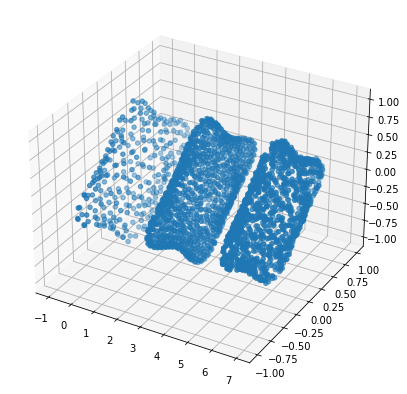

In [92]:
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection='3d')
viz_many_mpl([data.numpy(), gt.numpy(), out.numpy()], ax=ax) 

In [56]:
loss_fn = ChamferLoss()
losses = []
for file in tqdm(os.listdir(input_dir)):
    data = load_xyz_file(os.path.join(input_dir, file))
    gt = load_xyz_file(os.path.join(gt_dir, file))
    data = torch.tensor(data, dtype=torch.float32)
    gt = torch.tensor(gt, dtype=torch.float32)
    out = model(data)
    d1, d2, _, _ = loss_fn(out.unsqueeze(0).cuda(), gt.unsqueeze(0).cuda())
    loss = d1.mean() + d2.mean()
    losses.append(loss.item())
    

  0%|          | 0/127 [00:00<?, ?it/s]

In [59]:
np.mean(losses)

0.0009807185936759513